# Assignment 4

Approximate time needed: 6-7 hours
    
**DLT and Epipolar Lines**

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

1. For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

2. The second part of this assignment will require you to construct epipolar lines on two corresponding images.

3. The third part of this assignment will require you to use camera intrinsics to estimate the bounding box of a car.

In [1]:
# Import everything
import numpy as np
import cv2 as cv
print(f"Using OpenCV Version: {cv.__version__}")
from matplotlib import pyplot as plt

Using OpenCV Version: 4.5.3


---


## 4.1 DLT

The Direct Linear Transform method for camera calibration (using correspondences)

**References**

- Cyrill Stachniss YouTube videos
    - Camera Parameters: [long](https://www.youtube.com/watch?v=uHApDqH-8UE&t=1181s), [short](https://www.youtube.com/watch?v=ND2fa08vxkY)
    - Direct Linear Transform: [long](https://www.youtube.com/watch?v=3NcQbZu6xt8), [short](https://www.youtube.com/watch?v=Fdwa0UEJ_F8)
    - Zhang's Method: [long](https://www.youtube.com/watch?v=-9He7Nu3u8s), [short](https://www.youtube.com/watch?v=26nV4oDLiqc)

### Part 1: Generate Correspondences

The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [2]:
dlt_file_name = "./q1/dlt1.jpeg"

The given code was using matplotlib and was taking long durations to execute. It has been stored in a separate file and a version using [OpenCV](https://docs.opencv.org/4.x/) has been used here. The following are for reference

1. Basic image handling in OpenCV: tutorial [here](https://docs.opencv.org/4.x/db/deb/tutorial_display_image.html)
    1. [cv.imread](https://docs.opencv.org/4.x/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56): Reads an image and stores as numpy.ndarray, shape is (height, width, channels). Note that the channels in OpenCV are in BGR by default.
    2. [cv.imshow](https://docs.opencv.org/4.x/d7/dfc/group__highgui.html#ga453d42fe4cb60e5723281a89973ee563): View images
2. Mouse event handling in OpenCV: tutorial [here](https://docs.opencv.org/4.x/db/d5b/tutorial_py_mouse_handling.html)
    1. Window management: [cv.namedWindow](https://docs.opencv.org/4.x/d7/dfc/group__highgui.html#ga5afdf8410934fd099df85c75b2e0888b), [cv.resizeWindow](https://docs.opencv.org/4.x/d7/dfc/group__highgui.html#ga9e80e080f7ef33f897e415358aee7f7e), [cv.destroyWindow](https://docs.opencv.org/4.x/d7/dfc/group__highgui.html#ga851ccdd6961022d1d5b4c4f255dbab34)
    2. Assign callback function using [cv.setMouseCallback](https://docs.opencv.org/4.x/d7/dfc/group__highgui.html#ga89e7806b0a616f6f1d502bd8c183ad3e). The function takes five arguments: [event](https://docs.opencv.org/4.x/d0/d90/group__highgui__window__flags.html#ga927593befdddc7e7013602bca9b079b0), x, y (coordinates of operation), [flags](https://docs.opencv.org/4.x/d0/d90/group__highgui__window__flags.html#gaab4dc057947f70058c80626c9f1c25ce) and some additional parameters (can be passed). 
3. Drawing functions: tutorial [here](https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html)
    1. Draw a circle using [cv.circle](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670)
    2. Write text at a point using [cv.putText](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga5126f47f883d730f633d74f07456c576)

In [3]:
img = cv.imread(dlt_file_name)
_img = img.copy()   # Don't alter img
img_points = []
_img_col = []

def img_win_event(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONUP:
        print(f"Clicked on point (x, y): {x}, {y}")
        img_points.append([x, y])
        # Random color to the point (bright colors)
        _img_col.append(tuple(  # OpenCV needs tuple colors
            map(int, np.random.randint(100, 255, 3))))

img_winname = "Image"
cv.namedWindow(img_winname, cv.WINDOW_NORMAL)   # Resizable window
cv.resizeWindow(img_winname, 500, 900)  # Set initial size
cv.setMouseCallback(img_winname, img_win_event) # Attach mouse event

while True:
    cv.imshow(img_winname, _img)
    # Show the markers that are currently selected
    for i, ((cx, cy), col) in enumerate(zip(img_points, _img_col)):
        cv.circle(_img, (cx, cy), 15, col, -1)
        cv.putText(_img, f"{i+1}", (cx, cy-15), 
            cv.FONT_HERSHEY_SIMPLEX, 1.5, col, 2, cv.LINE_AA)
    k = cv.waitKey(1)
    if k == ord('q'):
        break

cv.destroyWindow(img_winname)
img_points = np.array(img_points)

Clicked on point (x, y): 350, 506
Clicked on point (x, y): 127, 581
Clicked on point (x, y): 516, 566
Clicked on point (x, y): 338, 735
Clicked on point (x, y): 320, 213
Clicked on point (x, y): 83, 342
Clicked on point (x, y): 569, 335


In [4]:
# In case the above code fails, close the window (prevent freezing)
cv.destroyAllWindows()

In [5]:
print(f"Image points are (x, y): \n{img_points}")
# Save it to a file
# np.save("./results/q1/image-points.npy", img_points)
# Retrieve from backup
# _img_points = np.load("./results/q1/image-points.npy")

Image points are (x, y): 
[[350 506]
 [127 581]
 [516 566]
 [338 735]
 [320 213]
 [ 83 342]
 [569 335]]


The image points are picked as follows

![Points on cube](./results/q1/cube-points.png)

The image coordinates are as follows (X, Y values)

```txt
array([[346, 501],
       [127, 582],
       [516, 567],
       [338, 735],
       [320, 215],
       [ 84, 340],
       [569, 334]])
```

7 points were chosen to experiment with an extra validation point


After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

Choosing the origin the point diagonally opposite to point `1` (hidden, innermost corner of the cube). The X axis is along the left edge of that point, Y axis is along the right edge of that point and the Z axis is upwards (towards point `5`). Using this, the point coordinates are derived. A side length is considered to be `4 units`.


In [6]:
world_points = np.array([   # Each index is [X, Y, Z]
    [4, 4, 4],  # Point 1
    [4, 0, 0],  # Point 2
    [0, 4, 0],  # Point 3
    [4, 4, 0],  # Point 4
    [0, 0, 4],  # Point 5
    [4, 0, 4],  # Point 6
    [0, 4, 4],  # Point 7
])

### Part 2: Calculate the Projection Matrix

Calculate the projection matrix $\mathbf{P}$ that relates the points in world frame to the points in the image coordinates.

Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [7]:
# Calculate and return the camera projection matrix P
def calc_P(wpts: np.ndarray, ipts: np.ndarray):
    """
        Calculates the camera projection matrix P, such that x = P * X
        where X is 4, 1 (homogenized world point) and x is 3, 1
        (homogenized image point). P is 3, 4: the camera projection
        matrix. Uses DLT method: At least 6 point correspondences (not
        lying in a plane) are needed.

        Parameters:
        - wpts: np.ndarray  shape: N, 3
            The points in the world coordinate (non-homogenized)
        - ipts: np.ndarray  shape: N, 2
            Non-homogenized point correspondences of the world points
            in the image
        
        Returns:
        - P: np.ndarray     shape: 3, 4
            The camera projection matrix. The norm of the flattened
            matrix (vector) is 1.
    """
    # Number of correspondences
    N = wpts.shape[0]
    # Homogenized correspondences
    X = np.hstack((wpts, np.ones((N, 1))))
    x = np.hstack((ipts, np.ones((N, 1))))
    # Homogenized equations for i: a_i * p = 0
    a_i = lambda i: np.vstack((
        np.hstack((-X[i], np.zeros(4), x[i][0]*X[i])),
        np.hstack((np.zeros(4), -X[i], x[i][1]*X[i]))
    ))
    # Stacked homogenized matrix: A * p = 0
    A = np.vstack([a_i(i) for i in range(N)])
    # -- p = Null space of A --
    # SVD of A
    U, D, Vh = np.linalg.svd(A)
    p = Vh.T[:, -1] # Last column of V
    # Reshape vector to matrix
    P = p.reshape(3, 4)
    return P


Estimate the Camera Projection matrix: $\mathbf{P}$

In [8]:
P = calc_P(world_points[0:6], img_points[0:6])
print(f"Camera projection matrix (3, 4) = \n{P}")

Camera projection matrix (3, 4) = 
[[-9.20055538e-02  6.97023244e-02 -2.41072100e-02  5.68618872e-01]
 [ 2.84494438e-02  3.13623412e-02 -1.22298700e-01  8.03750452e-01]
 [-5.56678991e-05 -3.98986999e-05 -8.13133794e-05  1.80149515e-03]]


In [9]:
# Test the camera projection (verification)
test_points = [1, 3, 7]    # Test points
dev_pix_thres = 10   # Threshold in pixel deviation (10 pixels)
for tp in test_points:
    t = tp - 1
    # Test point (world homogenized coordinates)
    test_X = np.hstack((world_points[t], 1)).T    # Point as 4, 1
    exp_x = np.hstack((img_points[t], 1)).T     # Point as 3, 1
    # Get x through P (P is )
    tx = P @ test_X
    if np.isclose(tx[2], 0):
        print("Point in P2 is at infinity (last value 0)")
    else:
        tx = tx / tx[2] # Normalize it (last element should be 1)
        dev = np.linalg.norm(exp_x - tx)
        if dev < dev_pix_thres:
            print(f"Test {tp}: Deviation of {dev:.3f} pixels")
        else:
            print(f"Test {tp}: Deviation = {dev:.3f}, too high!")

Test 1: Deviation of 0.243 pixels
Test 3: Deviation of 0.145 pixels
Test 7: Deviation of 1.609 pixels


As observed, there is very little deviation even in the 7th correspondence, though it wasn't used to find P. It can be included and the deviation will be even lesser (but let's keep it separate).

### Theory

- Explain how DLT is implemented and show why it works (proof)
- When does DLT fail?

#### DLT Explanation

The **Direct Linear Transform** is a method to extract a homogeneous relation between corresponding points. In the context of camera calibration, where the aim is to estimate the camera extrinsic and intrinsic parameters, it is the process of finding the camera projection matrix, given the point correspondences (pairs of relations, relating the 3D point coordinates in the world with the 2D image coordinates). Here, the projection equation is rearranged into an equation where finding the null space gives the resultant vector directly.


**Implementation**

The above implementation is described here as steps

1. **Correspondences**: The 3D world to 2D image point correspondences are obtained. Manual identification is used here, but this can be done by the help of a depth sensor, and detection algorithms with a camera (in a real setting). Basically, we have the correspondences $\mathbf{X}_i \leftrightarrow \mathbf{x}_i = [ X_i, Y_i, Z_i, 1 ] \leftrightarrow [ x_i, y_i, 1 ]$ (note that the correspondences are homogenized) relating the 3D point in world to point in pixel coordinates. These points are related as $\mathbf{x}_{i_{(3,1)}} = \mathbf{P}_{(3, 4)} \mathbf{X}_{i_{(4, 1)}}$ where the points are homogenized.
2. **Equation Modeling**: The homogeneous equation is created by rearranging the terms (from correspondences).

    $$
    \mathbf{A}_{(2m, 12)} \mathbf{p}_{(12, 1)} = 0 \quad \textup{where}\; \mathbf{p} = \begin{bmatrix}
        \mathbf{P}_{1,:}^\top \\ \mathbf{P}_{2,:}^\top \\ \mathbf{P}_{3,:}^\top
        \end{bmatrix} \; \textup{and} \; \mathbf{A} = \begin{bmatrix}
        \mathbf{a}_{x_1}^\top \\
        \mathbf{a}_{y_1}^\top \\
        \vdots \\
        \mathbf{a}_{x_i}^\top \\
        \mathbf{a}_{y_i}^\top \\
        \vdots \\
        \mathbf{a}_{x_m}^\top \\
        \mathbf{a}_{y_m}^\top \\
        \end{bmatrix} ; \; \begin{bmatrix}
        \mathbf{a}_{x_i}^\top \\
        \mathbf{a}_{y_i}^\top
        \end{bmatrix} = \begin{bmatrix}
        -\mathbf{X}_i^\top & \mathbf{0}^\top & x_i \mathbf{X}_i^\top \\
        \mathbf{0}^\top & -\mathbf{X}_i^\top & y_i \mathbf{X}_i^\top
        \end{bmatrix}
    $$

    The above formulation is true for $m$ correspondences, here $m=6$ is used (6 correspondences). It can be noted that vector $\mathbf{p}$ is created by using the rows of $\mathbf{P}$ and vertically stacking them as columns.

3. **Null Space**: The relation $\mathbf{Ap} = 0$ may not exactly hold true, mostly because of noisy correspondences, measurements, inexactness, numerical instability, etc. It is therefore best to minimize $\left \| \mathbf{Ap} \right \|$ under the constraint $\left \| \mathbf{p} \right \| = 1$. We perform the _Singular Value Decomposition_ of $\mathbf{A}$ and get the last column of matrix $\mathbf{V}$ (right eigenvectors) as $\mathbf{p}$. This result is the closest to the null space of $\mathbf{A}$.

Once we have $\mathbf{p}$, we can convert it back to $\mathbf{P}$ (break into parts of 4 and arrange the parts as rows). We have achieved the camera projection matrix.

**Proof** (why it works) through **Derivation**

From above, we get the ideal condition that

$$ \mathbf{A}_{(2m, 12)} \mathbf{p}_{(12, 1)} = 0 \rightarrow \mathbf{A} \mathbf{p} = 0 $$

Basically, $\mathbf{p}$ is _ideally_ the **null space** of matrix $\mathbf{A}$

However, in reality, $\mathbf{A} \mathbf{p} \approx 0$. This may be because of noisy correspondences, measurements, inexactness, numerical instability, etc. In this case, the objective becomes to get the determinant minimized. This means, we get the $\mathbf{p}$ vector as

$$ \mathbf{p} = \underset{\mathbf{p'}}{\textup{argmin}}  \left \| \mathbf{A\,p'} \right \| $$

Where $\left \| \mathbf{B} \right \|$ is the matrix determinant of $\mathbf{B}$. However, note that these are homogeneous equations. In order to avoid the trivial zero condition, and to get a unique solution (since the solutions are parameterized by 1 DoF), we set the constraint $\left \| \mathbf{p} \right \| = 1$ (where $\left \| \mathbf{b} \right \|$ is the norm of the vector $\mathbf{b}$). Now, the problem becomes

$$ \textup{min} \left \| \mathbf{A\,p} \right \| \quad \textup{such that} \, \left \| \mathbf{p} \right \| = 1 $$

Through SVD (Singular Value Decomposition), we can write $\mathbf{A} = \mathbf{UDV^\top}$. Note that $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices (determinant is 1 and inverse is the same as transpose). We get

$$ \textup{min} \left \| \mathbf{UDV^\top \,p} \right \| \quad \textup{such that} \, \left \| \mathbf{p} \right \| = 1 $$

We can get a separate vector for the last term, that is $\mathbf{y} = \mathbf{V^\top p}$. Note that since $\mathbf{V}$ is orthogonal (so is its transpose), $\left \| \mathbf{y} \right \| = \left \| \mathbf{V^\top \, p} \right \| = \left \| \mathbf{p} \right \| = 1$ (we can modify the constraint). The problem is now formatted as

$$ \textup{min} \left \| \mathbf{UD \, y} \right \| \quad \textup{such that} \, \left \| \mathbf{y} \right \| = 1 $$

Since $\mathbf{U}$ is orthogonal (determinant is 1) and determinant is distributive over product, $\left \| \mathbf{UD \, y} \right \| = \left \| \mathbf{D \, y} \right \|$. This gives

$$ \textup{min} \left \| \mathbf{D \, y} \right \| \quad \textup{such that} \, \left \| \mathbf{y} \right \| = 1 $$

Note that $\mathbf{D}$ is a diagonal matrix, with the entries in descending order (a property of SVD implementation). The **best** method of getting the smallest value out of it will be when only that smallest diagonal entry is returned by $\left \| \mathbf{D \, y} \right \|$. This smallest diagonal entry is also the last element of the diagonal. To pick that element, we have to use $\mathbf{y} = \left [ 0, 0, \cdots, 0, 1 \right ]$.

We can note that $\mathbf{y} = \mathbf{V^\top \, p} \Rightarrow \mathbf{p} = \mathbf{V \, y}$ and when $\mathbf{y} = \left [ 0, 0, \cdots, 0, 1 \right ]$, we are essentially picking the **last column** of $\mathbf{V}$ matrix. Hence, $\mathbf{p}$ is the last column of $\mathbf{V}$.

Note that $\mathbf{p}$ was obtained by using the rows of $\mathbf{P}$ matrix (the main projection matrix) and vertically stacking them as a long (12, 1) column vector. We can now again break $\mathbf{p}$ vector into three parts (four elements each), arrange these parts as rows of a matrix and stack them into forming the (3, 4) **projection matrix** $\mathbf{P}$.

As seen through the above proof, choosing the last column of the matrix $\mathbf{D}$ (diagonal matrix of singular values in descending order) minimizes $\left \| \mathbf{D \, y} \right \|$, where $\mathbf{y} = \mathbf{V^\top \, p}$. Therefore, $\mathbf{p}$ obtained (through the last column of $\mathbf{V}$) is the most **optimal** solution.

#### DLT Shortcomings

In order to use DLT, we need to satisfy the following constraints

1. Each point brings with it two constraints (one in $x$ and another in $y$ of image coordinate). Since the camera projection matrix has 11 degrees of freedom / unknown parameters (5 intrinsic and 6 extrinsic), **we will require at least 6 correspondences** to find the correct $\mathbf{P}$ matrix.
2. It is important that $\mathbf{A}$ does not loose rank. This will happen when all the points lie on a plane (that is, all the correspondences actually lie one a flat plane in the real world). In this case, since it will be possible to represent different rows (consecutive pairs of them) in linear combinations of others, the matrix $\mathbf{A}$ will loose rank. In this case, finding the matrix $\mathbf{P}$ becomes impossible (as at least one singular value will become 0).

Hence, DLT will fail if we have fewer than 6 correspondences or if the points in the world lie in a plane.

### Part 3: Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix. Note that the last point is not used here because it wasn't used to find $\mathbf{P}$ (it's only for cross-validation).

In [10]:
#Get reprojected points
def get_points(P: np.ndarray, X_world: np.ndarray):
    X = np.hstack((X_world, np.ones((X_world.shape[0], 1)))).T
    _x = P @ X  # Homogeneous image points as 3, N
    return _x / _x[2]   # Normalize the h-points (last value 1)

#Get reprojection error
def get_err(x_img, X_world, P):
    # Actual value (correspondences)
    x = np.hstack((x_img, np.ones((x_img.shape[0], 1)))).T
    # From P (re-projection)
    _x = get_points(P, X_world)
    # Get reprojection error
    d_vect = _x - x
    r_err = np.sum(np.linalg.norm(d_vect, axis=0)**2)
    return r_err

In [11]:
x, X = img_points[0:6], world_points[0:6]   # All points used
r_err = get_err(x, X, P)
print(f"Reprojection Error is {r_err:.5f}")

Reprojection Error is 0.28139


### Part 4: Getting intrinsic and extrinsic parameters

Now that $\mathbf{P}$ is known, get the intrinsic parameters (matrix $\mathbf{K}$) and the extrinsic parameters (matrix $\left [ \mathbf{R} | \mathbf{t} \right ]$).


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

**Method**

We can write the camera projection matrix as

$$ \mathbf{P} = \mathbf{K R} \left [ \mathbf{I} \mid -\mathbf{X}_O \right ] = \left [ \mathbf{K R} \mid -\mathbf{K R} \, \mathbf{X}_O \right ] $$

Assuming $\mathbf{H} = \mathbf{K R}$ and $\mathbf{h} = - \mathbf{K R} \, \mathbf{X}_O = -\mathbf{H} \, \mathbf{X}_O$, we can readjust the above equations as

$$ \mathbf{P} = \left [ \mathbf{H \mid h} \right ] $$

From this, it is clear that $\mathbf{X}_O = -\mathbf{H}^{-1} \mathbf{h}$. Now, we only need to find $\mathbf{R}$ (rotation matrix) and $\mathbf{K}$ (the camera calibration matrix). Let's see the inverse of $\mathbf{H}$

$$ \mathbf{H}^{-1} = \left( \mathbf{KR} \right )^{-1} = \mathbf{R}^{-1} \, \mathbf{K}^{-1} = \mathbf{R}^\top \, \mathbf{K}^{-1} $$

Performing the [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition) of $\mathbf{H}^{-1}$ (this can be done using [numpy.linalg.qr](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html) in numpy), we can decompose it into $\mathbf{H}^{-1} = QR$ (here, $Q$ is an orthogonal matrix and $R$ is an upper / right triangular matrix). We now finally have $Q \equiv \mathbf{R}^\top$ and $R \equiv \mathbf{K}^{-1}$. This gives us

$$ \mathbf{R} = Q^\top \quad \textup{and} \quad \mathbf{K} = R^{-1} $$

Note that because of the camera image coordinates, the screen placement has been emulated to be in the front of the camera. This will require adjustment (as it has to be behind the principle / pole of the camera). A simple 180 degree rotation to $\mathbf{R}$ about the Z axis of the world (vertically up) should work (this is transform w.r.t. a fixed frame, so pre-multiply it). The same adjustment will then also be needed for $\mathbf{K}$, but, to maintain the $\mathbf{H} = \mathbf{KR}$ relation, the adjustment to K will be a pose-multiplication. Also, K has to be homogenized (the last element has to be scaled to 1). This means, the last step for rectification is as follows

$$ \mathbf{R} \leftarrow \textup{Rot}(\mathbf{Z}, \pi) \times \mathbf{R} \quad \textup{and} \quad \mathbf{K} \leftarrow \frac{\mathbf{K} \times \textup{Rot}(\mathbf{Z}, \pi)}{K_{3,3}} $$

Where $\textup{Rot}(\mathbf{Z}, \pi) = \textup{diag}(-1, -1, 1)$ and $K_{3,3}$ is the last row's last column element of $\mathbf{K}$. With this rectification, the intrinsic and extrinsic parameters have been obtained. Note that there must be a negative focal length in Y direction (image is vertically inverted in the pinhole model).


In [12]:
def ret_RKT(P):
    # Decompose into H matrix and h vector
    H = P[0:3, 0:3]
    h = P[0:3, 3]
    # Retrieve X_O
    X_O = -np.linalg.inv(H) @ h
    # Invert H
    H_inv = np.linalg.inv(H)
    # QR Decomposition to H_inv
    q, r = np.linalg.qr(H_inv)
    rot_z_pi = np.diag([-1, -1, 1])
    # R calculation
    R = q.T
    R = rot_z_pi @ R
    # K calculation
    K = np.linalg.inv(r)
    K = K @ rot_z_pi / K[2,2]
    return R, K, X_O

R, K, T = ret_RKT(P)

In [13]:
# Reconstruct the P matrix using K, R, T (= X_O)
P_re = K @ R @ np.hstack((np.eye(3), -T.reshape(3, 1)))
# Calculate reprojection error
rp_err = get_err(img_points[0:6], world_points[0:6], P_re)
# This should be the same as before
print(f"Reprojection error (from reconstructed P) is {rp_err:.5f}")

Reprojection error (from reconstructed P) is 0.28139


#### Verifying the R, K, T Values

Use `np.isclose` to verify the matrix

In [14]:
if np.allclose(R @ R.T, np.eye(3)):
    print("Rotation Matrix is orthogonal")
if np.allclose(P / P[2, 3], P_re / P_re[2, 3]):
    print("The intrinsic and extrinsic parameters seem to produce the"
        " same matrix (homogenized) by setting the last element to 1")

Rotation Matrix is orthogonal
The intrinsic and extrinsic parameters seem to produce the same matrix (homogenized) by setting the last element to 1


**Reproject the world points with P matrix you have obtained via DLT and visualize**

In [15]:
# Get the world points in homogeneous coordinates
X_world = world_points
X = np.hstack((X_world, np.ones((X_world.shape[0], 1)))).T
_x = P_re @ X
x = _x / _x[2]
reimg_points = x[0:2, :].T

Marker: + for actual and x for re-projection


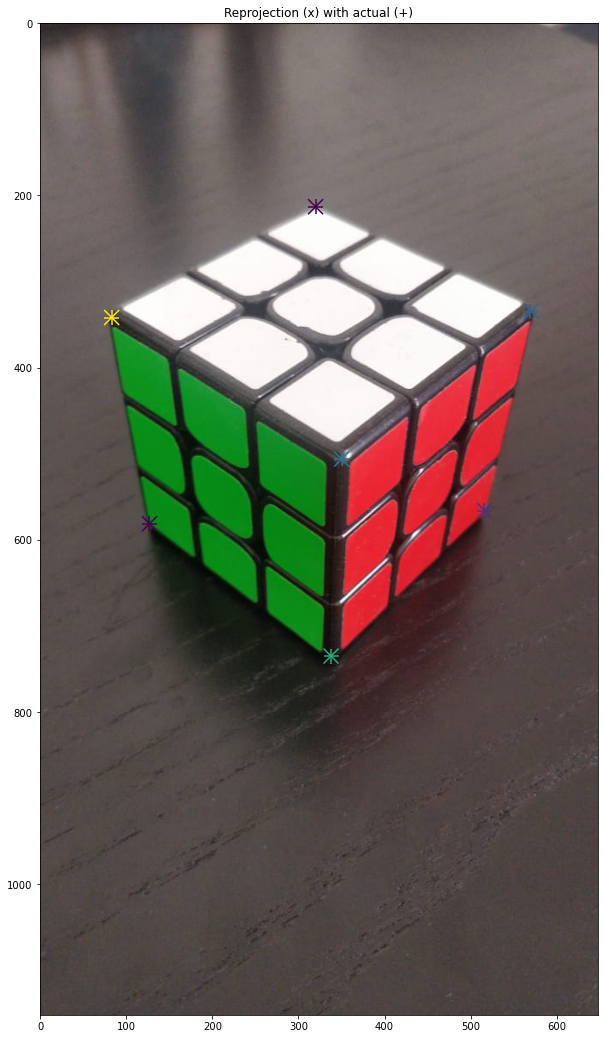

In [18]:
# OpenCV to Matplotlib (BGR to RGB)
img_plt = img.copy()
img_plt = cv.cvtColor(img_plt, cv.COLOR_BGR2RGB)
# Show image
plt.figure(figsize=(10, 20))
N = reimg_points.shape[0]   # Number of points
colors = np.random.rand(N)
area = (15 * np.ones(N))**2
print("Marker: + for actual and x for re-projection")
plt.title("Reprojection (x) with actual (+)")
# Color of markers
plt.imshow(img_plt)
# Image points
plt.scatter(img_points[:, 0], img_points[:, 1], c=colors, s=area, 
    marker="+")
# Re-projected image points
plt.scatter(reimg_points[:, 0], reimg_points[:, 1], c=colors, s=area, 
    marker="x")
plt.show()

The reprojected points reproject as shown (may slightly vary by run)

![Reprojected points](./results/q1/reprojection-output.png)

Notice how only the seventh correspondence is not very accurate, rest all are very spot on (`+` is actual, `x` is re-projected).


### Part 5: Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in `q1/zhangs` folder for this task. Familiarize yourself with the different parameters for this method.

**Reference**

- OpenCV Tutorial: Link [here](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html)
- Paper: [Z. Zhang (2000) - A flexible new technique for camera calibration](https://academic.microsoft.com/paper/2167667767)

In [66]:
# Import items specifically for this
import glob
import copy

Set the variables below before proceeding

1. `zhangs_chb_imgs`: Folder containing the images. Must be regex like, searchable through [glob](https://docs.python.org/3/library/glob.html#module-glob)
2. `cb_nrows`, `cb_ncols`: Number of rows and columns (inner intersections) in the checkerboard pattern.
3. `criteria`: Termination criteria as used by OpenCV. C++ description [here](https://docs.opencv.org/4.x/d9/d5d/classcv_1_1TermCriteria.html#a56fecdc291ccaba8aad27d67ccf72c57)

    Get a list of them using

    ```py
    c = [i for i in dir(cv) if 'TERM_CRITERIA' in i]
    print(c)
    ```

4. `wait_nopress`: Wait duration per image (for inspection of corners)

In [101]:
# Configurations
zhangs_chb_imgs = "./q1/Zhangs/*.JPG"   # Checkerboard images path
cb_nrows, cb_ncols = 6, 8   # No. of rows, columns for checkerboard
# Termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 
    30, 0.001)  # 30 iter or change less than 0.001
# Wait duration
wait_nopress = 1000 # Wait for 1000 milliseconds (or until keypress)

In [102]:
# Find all files
img_files = glob.glob(zhangs_chb_imgs)
if len(img_files) > 0:
    print(f"Found {len(img_files)} images in '{zhangs_chb_imgs}'")
else:
    print(f"ERROR: Check if path '{zhangs_chb_imgs}' has images")

Found 15 images in './q1/Zhangs/*.JPG'


In [114]:
# Object coordinates (meshgrid) -> (X, Y, Z = 0)
# Vector of (0,0,0), (1,0,0), (2,0,0) ....,(cb_nrows, cb_ncols,0)
objp = np.array(
    [a.T 
        for a in np.meshgrid(
            np.arange(cb_nrows), np.arange(cb_ncols)
        )
    ]  # Shape
    ).T.reshape(-1, 2)
objp = np.hstack((objp, np.zeros((objp.shape[0], 1))))  # Object coord
objp = objp.astype(np.float32)  # Float32 for OpenCV

Run the corner detection and visualization on all images, detect the corner points, visualize and store them. The following is for reference

1. [cv.findChessboardCorners](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a): Finds internal corners of chessboard patterns. All images in the folder are expected to have it (`WARN`ing message is shown otherwise). The detected coordinates are approximate, and to determine their positions more accurately, the function calls cornerSubPix. We call this function again with custom convergence parameters.
2. [cv.cornerSubPix](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e): Refines corner positions using image gradients. Note that the corners taken by the function is also modified.
3. [cv.drawChessboardCorners](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022): Draw the chessboard corners (renders on image).

In [135]:
# Store object and image points from all images
obj_pts = []    # List of X, Y, Z points in space
img_pts = []    # List of x, y points in image plane (detected)

# Window (for displaying results)
img_winname = "Checkerboard Detection Results"
cv.namedWindow(img_winname, cv.WINDOW_NORMAL)
cv.resizeWindow(img_winname, 900, 600)
# Detection for each candidate file
for i, cb_cand_fname in enumerate(img_files):
    img = cv.imread(cb_cand_fname)  # Read image
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Greyscale conversion
    # Find chessboard corners
    cfound, corners = cv.findChessboardCorners(gray, 
        (cb_nrows, cb_ncols))   # Find coarse corners
    # If corners were found
    if cfound:
        # Append all world points (fixed for all images)
        obj_pts.append(objp)
        # Refine corners
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1),
            criteria)   # Note that `corners` is also modified
        # Image corner points (x, y pixel coordinates)
        img_pts.append(copy.deepcopy(corners))
        # Draw and display the corners
        cv.drawChessboardCorners(img, (cb_nrows, cb_ncols), corners2, 
            cfound) # Renders on 'img' (color image)
        cv.imshow(img_winname, img)
        cv.waitKey(wait_nopress)
    else:
        print(f"WARN: No corners found in file no. {i}")
# Cleanup
cv.destroyWindow(img_winname)

In [116]:
# Failsafe, in case something crashes above and the window freezes
cv.destroyAllWindows()

Camera calibration using OpenCV. Use the function [cv.calibrateCamera](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga687a1ab946686f0d85ae0363b5af1d7b) (which is an overload of [this](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d)).

The return values have the following description

1. `ret`: The overall RMS re-projection error
2. `mtx`: The camera matrix, denoted by $\mathbf{K}$ in the above steps (prior to this one)
3. `dist`: Distortion coefficients. The five coefficients are $(k_1, \; k_2, \; p_1, \; p_2, \; k_3)$, where $k_1, \; k_2, \; k_3$ are for radial distortion and $p_1, \; p_2$ are for tangential distortion
4. `rvecs`: List of rotation vectors estimated for each pattern. Each item is of shape $3, 1$ and is in the [Rodrigues](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga61585db663d9da06b68e70cfbf6a1eac) form (exponential coordinates). This must be coupled with the translation vectors (described next)
5. `tvecs`: List of translation vectors for each pattern view. Must be coupled with the elements of `rvecs` (described above)

Passed parameters are as follows

1. `obj_pts`: List of object points (for each image). List must be 15 element long (15 images). Each element must be $48, 3$, (since $48 = 6 \times 8$, the number of corners) which gives the $X, Y, Z$ world coordinates of the corners. Since the checkerboard is on a plane, $Z = 0$ here.
2. `img_pts`: List of image points (correspondences for each image). List must be 15 elements long (for 15 images). Each element must be $48, 1, 2$ or $48, 2$ which gives the $u, v$ image coordinates of the corners. All data-types are 32-bit floats.
3. `gray.shape[::-1]`: The shape of the image, might as well write `[5472, 3648]` which is the $[width, height]$ of images (for estimate of the sizes in $\mathbf{K}$, for origin offset to the center of image).
4. The following two parameters are for no prior estimates.

In [129]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(obj_pts, img_pts, 
    gray.shape[::-1], None, None)   # size of img, None initial value

This thereby gives us all the camera parameters in `mtx` (intrinsic parameters, given by $\mathbf{K}$, which is an upper triangular matrix).


---

## 4.2 Epipolar lines

### Task 1

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix from these two images.

<img src="./q2/img1.jpg" alt="image 1" width="400"/>
<img src="./q2/img2.jpg" alt="image 2" width="400"/>


Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions. 

**Provide a clear explanation on your approach for both this task and the next**

### Task 2

Report the location of the epipoles. Mathematically find the epipoles and verify that the lines intersect at the epipole.

---


## 4.3 Drawing a bounding box around a car and localizing it in the camera frame

You’ve been provided with an image, also taken from a self-driving car, that shows another car in front. The camera has been placed on top of the car, 1.65 m from the ground, and assume the image plane is perfectly perpendicular to the ground. K is provided to you. Your task is to draw a 3D-bounding box around the car in front as shown. Your approach should be to place eight points in the 3D world such that they surround all the corners of the car, then project them onto the image, and connect the projected image points using lines. You might have to apply a small 5° rotation about the vertical axis to align the box perfectly. Rough dimensions of the car - h: 1.38 m, w: 1.51, l: 4.10. (Hint: Fix a point on the ground as your world origin.). Also estimate the approximate translation vector to the mid-point of the two rear wheels of the car in the camera frame.

![Kitti car](./q3/image.png)